In [45]:
""" A genetic algorithm which evolves quantum circuits according to a goal circuit """
import random
import numpy as np
import math
from deap import base, creator, tools
from qiskit import QuantumCircuit
from qiskit.primitives.sampler import Sampler
# Imports the circuits, gate sets and sets of possible gates to be used for both problems
# from grover_circuits import *
from qft_circuits import *
from grover_circuits import *
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

def random_gate():
    """ Picks and returns a random item from the gate set
    """
    return random.choice(gpossible_gates_2)

def circuit_fitness(current_circuit, gate_set, target_matrix, num_qubits):
    """ Compares the unitary matrix from the provided circuit with the unitary
    matrix representing the target circuit
    """
    # Convert the representation of the current circuit into a QuantumCircuit
    # object
    qiskit_representation = convert_circuit(current_circuit, num_qubits, gate_set)
    # An element to element comparison between the current circuit and the target matrix
    circuit_unitary_matrix = qi.Operator(qiskit_representation)
    circuit_unitary_matrix = circuit_unitary_matrix.data
    # The circuit's fitness is the sum of the absolute element to element difference
    fitness = 0
    for i in range(0, len(circuit_unitary_matrix)):
        for j in range(0, len(circuit_unitary_matrix[i])):
            fitness += abs(circuit_unitary_matrix[i][j] - target_matrix[i][j])

    # Deap requires all fitness functions to return a tuple (even single objective functions)
    # The size of the circuit is also returned to enbale the EA to be multi-objective
    # as such that it minimises the size of the circuits in the population as well
    return (fitness, qiskit_representation.size())

def circuit_size(current_circuit):
    """Calculates the 'size' of a provided circuit, where this is the
    number of gates in the circuit.
    """
    size = 0
    for gate in current_circuit:
        if gate[0] != 10:
            size += 1

    return size

def convert_circuit(current_circuit, num_qubits, gate_set):
    """ Converts a given solution into a Qiskit QuantumCircuit object
    """
    # Creates a new QuantumCircuit object to add the values to
    circuit = QuantumCircuit(num_qubits)
    for gate in current_circuit:
        # If the current gate is anything but a wire, decompose the gate and add it to the qiskit quantum circuit
        if gate_set[gate[0]] != 'WIRE':
            circuit.append(
                gate_set[gate[0]],
                gate[1]
            )

    return circuit

def mutate(circuit):
    """ Mutates a gate in the given circuit by changing it to another gate from the provided gate set at random (valid gates only?) 
    """
    # Declare the set of possible valid mutations
    possible_gates = gpossible_gates_2
    
    # Choose a random gate in the circuit via index
    mutation_index = random.randint(0, len(circuit) - 1)
    # Choose a random gate from the gate set to replace said gate
    circuit[mutation_index] = random.choice(possible_gates)

    # Need to delete the mutated individuals fitness values as they are no
    # longer related to the individual
    del circuit.fitness.values

    return circuit    

def crossover(circuit1, circuit2):
    """ Performs an inplace two/ multipoint crossover between two circuits
    """
    # For the minimum viable product 2-point crossover is used
    # For the final product use a randomly selected multi-point crossover
    num_points = 2
    # Choose num_points random indcies to swap
    # If there is an odd number of points selected, the end of the list is
    # chosen as the end point for the second crossover
    if num_points%2 != 0:
        indicies = []
        indicies.append(len(circuit1) - 1)
    else:
        indicies = []
    
    # Validate that no two crossover points are the same
    for i in range(0, num_points):
        temp_index = random.randint(0, len(circuit1) - 1)
        while temp_index in indicies:
            temp_index = random.randint(0, len(circuit1) - 1)

        indicies.append(temp_index)

    # Sort the list of indexes so that the crossover can be performed correctly
    indicies.sort()

    # Perform the crossover in place, swapping all values between the crossover points
    for i in range(0, len(indicies), 2):
        temp_values = circuit1[indicies[i]:indicies[i+1]]
        circuit1[indicies[i]: indicies[i+1]] = circuit2[indicies[i]: indicies[i+1]]
        circuit2[indicies[i]: indicies[i+1]] = temp_values

    # Delete the fitness values associated with the "mated" circuits
    # As they are no longer related to the individual
    del circuit1.fitness.values
    del circuit2.fitness.values

    return (circuit1, circuit2)  

# Create the gate set (actually a dictionary where the key value pair is indexes and the Qiskit gate name)
# The number of qubits supplied here is the same as the number of quibts being looked at in the rest of the program

# Can't hardcode the array values for the target unitary matrix as the values are rounded implicitly

# Not decomposing the goal circuit as it seems to have at least some affect on the values stored in the unitary matrix representing the circuit
CIRCUIT_TYPE = "grover"
# QFT circuits only need to decomposed once, whereas Grover's algorithm circuits need to be decomposed twice
if CIRCUIT_TYPE == "qft":
    # The two qubit QFT circuit is being created in this instance
    goal_circuit = qft_circuit3
    gate_set = qgate_set3
    goal_circuit.decompose().draw(output="latex", filename="test_circuit.pdf")
    goal_matrix = qi.Operator(goal_circuit)
    goal_matrix = goal_matrix.data
    goal_circuit = qft_circuit3.decompose()
elif CIRCUIT_TYPE == "grover":
    # The two qubit Grover circuit is being created in this instance
    goal_circuit = grover_circuit2
    gate_set = ggate_set2
    goal_circuit.decompose().decompose().draw(output="latex", filename="test_circuit.pdf")
    goal_matrix = qi.Operator(goal_circuit)
    goal_matrix = goal_matrix.data
    goal_circuit = grover_circuit2.decompose().decompose()

# Create a basic minimising fitness object (This should attempt to minimise the difference between the unitary matrices between circuits)
# creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
# Create a basic object for each inidivdual in the population (an empty list) with a fitness linked to the above fitness object
creator.create("Individual", list, fitness=creator.FitnessMin)

# The max length of a circuit (the maximum number of gates in the circuit)
# This is set to 1 + the length of the desired circuit to allow for alternative circuits to be made
CIRCUIT_LENGTH = goal_circuit.decompose().size() + 1

toolbox = base.Toolbox()
# The genes in the genome (objects that make up an individual)
toolbox.register("attribute_gate", random_gate,)
# Second argument for the register method, this redirects to the initRepeat
# function, creating an individual and repeatedly (CIRCUIT_LENGTH times)
# filling the circuit with random gates
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute_gate, n=CIRCUIT_LENGTH)
# A bag population (one without any ordering) is used and regsitered with the toolbox accordingly
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Using the toolbox to register tools instead of using them independently helps
# keep the rest of the algorithms independent from the operator set - also
# makes it easier to locate and change any tools in the toolbox
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate)
# toolbox.register("select", tournament_selection)
# The NSGA II algorithm is used for selection as it is multi-objective
# Only 95 individuals are chosen as the remaining 5 are provided from intial elitist selection
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", circuit_fitness, gate_set=gate_set, target_matrix=goal_matrix, num_qubits=3)
# The use of the toolbox allows for algorithms that resemble pseudocode as closely as possible (as generic as possible)

# Register the statistics object to track the statistics/ progress of the genetic algorithm
statistics_fitness = tools.Statistics(key=lambda ind: ind.fitness.values[0])
statistics_size = tools.Statistics(key=circuit_size)
m_statistics = tools.MultiStatistics(fitness=statistics_fitness, size=statistics_size)
m_statistics.register("average", np.mean)
# To cut down on statistical compilation time, this statistic has been excluded
# m_statistics.register("standard deviation", np.std)
m_statistics.register("minimum", np.min)
m_statistics.register("maximum", np.max)

logbook = tools.Logbook()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit/visualization/circuit/latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class n

In [46]:
def main():
    """ The main program function that executes the genetic algorithm
    """
    # The parameters used by the EA are each ascribed their optimal value
    NUM_GENERATIONS = 400
    POP_SIZE = 600
    MUTATION_RATE = 0.8
    CROSSOVER_RATE = 0.6
    ELITISM_RATE = math.floor(0.05 * POP_SIZE)
    # Create an initial population of 100 circuits (individual circuits stored as a list)
    population = toolbox.population(n=POP_SIZE)

    # Stores the genetic representation and fitness values of the best solution found thus far
    # Initialised with placeholder values
    best_solution = [(math.inf, math.inf), 0]

    # Validate the fitness value of all circuits (this is done so any elite circuits carried over from the first generation have a valid fitness.values attribute)
    for circuit in population:
        circuit.fitness.values = circuit_fitness(circuit, gate_set, goal_matrix, 3)

    for gen in range(0, NUM_GENERATIONS):
        # Select the individuals to be used in the current generation
        # offspring = toolbox.select(population, 100, 10, gate_set, goal_matrix)
        # Select the individuals to be used in the population 
        offspring = toolbox.select(population, len(population))
        # Clone the selected population so that it can be altered
        offspring = list(map(toolbox.clone, offspring))

        next_gen_population = []
        # NSGA II returns the individuals in order of fitness, so the first item in the population is the fittest
        (bog_fitness, bog_size) = circuit_fitness(offspring[0], gate_set, goal_matrix, 3)

        if (bog_fitness < best_solution[0][0]): #and (bog_size <= best_solution[0][1]):
            best_solution[0] = (bog_fitness, bog_size)
            best_solution[1] = offspring[0]
        # elif (bog_fitness == best_solution[0][0]) and (bog_size < best_solution[0][1]):
        #     best_solution[0] = (bog_fitness, bog_size)
        #     best_solution[1] = offspring[0]

        # Choose the elite circuits to carry over into the next population (according to the elitism rate)
        for member in offspring:
            next_gen_population.append(member)

        next_gen_population = next_gen_population[:ELITISM_RATE:]

        # Apply crossover to this generation of circuits
        for c1, c2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CROSSOVER_RATE:
                toolbox.mate(c1, c2)
                # Delete the fitness values from the parent circuits as they have been
                # altered (value no longer corresponds to the circuits actual fitness)
                del c1.fitness.values
                del c2.fitness.values
        
        # Apply mutation to this generation of circuits
        for child in offspring:
            if random.random() < MUTATION_RATE:
                toolbox.mutate(child)
                # For the aforementioned reason, delete the circuits fitness value
                del child.fitness.values

        # Revalidates the fitness of individuals that have an invalid fitness
        # First find and store all the circuits that have an invalid fitness value
        altered_circuits = []
        for child in offspring:
            if not child.fitness.valid:
                altered_circuits.append(child)
        
        fitnesses = toolbox.map(toolbox.evaluate, altered_circuits)
        for (circuit, fitness) in zip(altered_circuits, fitnesses):
            circuit.fitness.values = fitness

        # Randomly pick circuits from the offspring to fill up the rest of the population to be used in the next generation
        while len(next_gen_population) < len(population):
            chosen_circuit = random.choice(offspring)
            next_gen_population.append(chosen_circuit)
            # Remove the circuit, so there is less chance duplicate individuals end up in the next generation
            offspring.remove(chosen_circuit)    

        # The population is updated
        population[:] = next_gen_population
        record = m_statistics.compile(population)
        logbook.record(**record)
    
    # Outputs the circuit representation of the best circuit found
    best_circuit = convert_circuit(best_solution[1], 4, gate_set)
    print("the size of the best circuit is:", best_solution[0][1])
    print("The best circuit had a fitness of", best_solution[0][0], "and is represented by:")
    print(best_circuit)
    # Further outputs the list of qiskit commands and the unitary matrix representing the best solution
    best_circuit_matrix = qi.Operator(best_circuit)
    print(best_circuit_matrix.data)
    best_circuit.draw(output="latex", filename="best_circuit.pdf")
    return logbook

In [47]:
def genetic_algorithm_results_plotter(logbook):
    """ Given the contents of the logbook, compile and display graphs to illustrate the performance of the algorithm over a given evolution
    """
    NUM_GENERATIONS = 400
    logbook.header = "fitness", "size"
    logbook.chapters["fitness"].header = "average"
    logbook.chapters["size"].header = "average"

    # The first graph maps the average fitness values over the evolution
    xaxis = [i for i in range(1,NUM_GENERATIONS + 1)]
    # The average fitness values across the evolution
    yaxis1 = logbook.chapters["fitness"].select("average")
    plt.plot(xaxis, yaxis1)

    # The titles for the first graph
    plt.title("Average Circuit Fitness Over the Evolution")
    plt.xlabel("Generation")
    plt.ylabel("Average Circuit Fitness")

    plt.show()

    # The second graph maps the fitness values over the evolution
    yaxis2 = logbook.chapters["fitness"].select("minimum")
    plt.plot(xaxis, yaxis2)

    # The titles for the second graph
    plt.title("Minimum Circuit Fitness Over the Evolution")
    plt.xlabel("Generation")
    plt.ylabel("Minimum Circuit Fitness")

    plt.show()
    
    # The third graph maps the average size of circuits over the evolution
    # The average size values across the evolution
    yaxis3 = logbook.chapters["size"].select("average")
    plt.plot(xaxis, yaxis3)

    # The titles for the third graph
    plt.title("Average Circuit Size Over the Evolution")
    plt.xlabel("Generation")
    plt.ylabel("Average Circuit Size")

    plt.show()

20.50609665440986 40
taken!
24.04163056034258 34
24.04163056034258 34
24.74873734152913 33
19.091883092036777 38
taken!
22.62741699796949 31
25.313708498984738 31
22.89949493661165 31
20.506096654409873 31
20.506096654409873 31
25.455844122715686 28
19.899494936611646 40
24.74873734152913 28
19.79898987322332 27
19.79898987322332 27
19.79898987322332 27
19.79898987322332 27
27.142135623730926 25
27.142135623730926 25
23.334523779156054 24
23.334523779156054 24
23.334523779156054 24
23.33452377915605 24
20.020815280171288 27
20.020815280171288 27
19.091883092036767 27
taken!
23.899494936611642 20
21.213203435596398 23
19.091883092036767 29
19.091883092036767 29
19.091883092036767 29
23.727922061357834 18
20.50609665440986 17
20.50609665440986 17
20.50609665440986 17
23.334523779156047 18
19.313708498984738 28
19.313708498984738 28
18.606601717798192 29
taken!
19.07106781186546 20
24.748737341529143 16
24.748737341529143 16
22.627416997969497 18
18.38477631085024 40
taken!
18.38477631085

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit/visualization/circuit/latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)


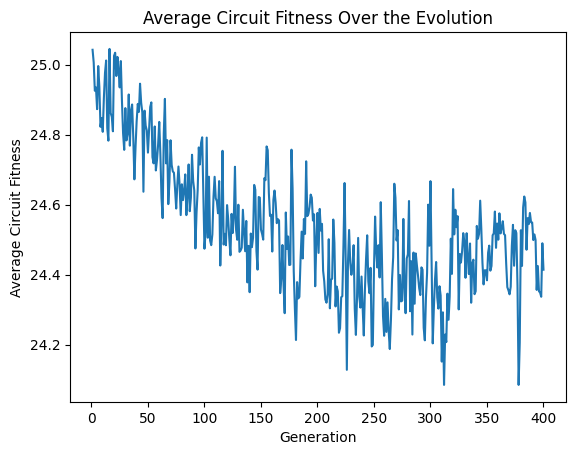

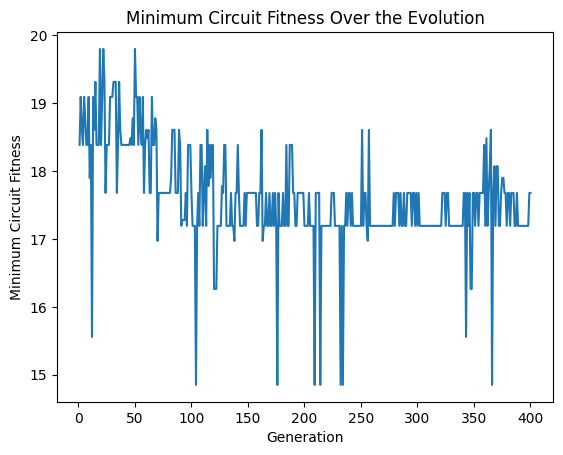

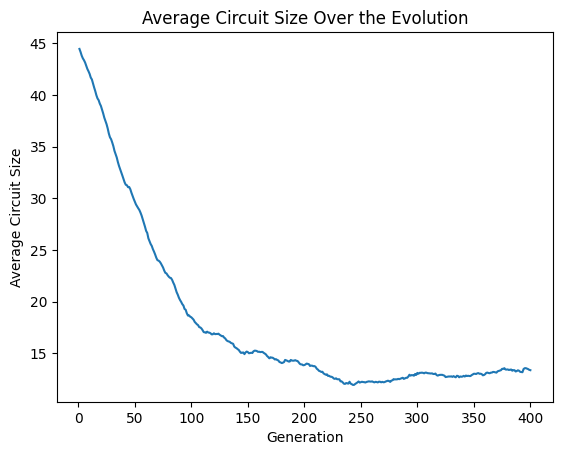

In [48]:
if __name__ == "__main__":
    data = main()
    # Create and display graphs on the algorithm's performance over the evolution
    genetic_algorithm_results_plotter(data)